# Machine Learning Volatility Modeling
## Master's Thesis - Empirical Study 
### Università della Svizzera italiana

Pietro Bonazzi - pietro.bonazzi@usi.ch

Model Deployment - v.4

In [1]:
# General imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import platform
import tensorflow as tf

# Import custom made modules
import import_ipynb
from vol_models_v4_deploy_v3 import *  # Import all functions from vol_models_v4_deploy.py

importing Jupyter notebook from vol_models_v4_deploy_v3.ipynb


In [2]:
# Verify Python environment and system
print('Python version: ', platform.python_version())
print('System: ', platform.system())
print('Version: ', platform.version())
print('Machine: ', platform.machine())

Python version:  3.11.7
System:  Darwin
Version:  Darwin Kernel Version 23.1.0: Mon Oct  9 21:28:12 PDT 2023; root:xnu-10002.41.9~6/RELEASE_ARM64_T8103
Machine:  arm64


In [3]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

## Final deployment

In [4]:
# Database connection and data import
conn = sqlite3.connect('data.db')

# Read all stocks
query = "SELECT name FROM sqlite_master WHERE type='table' AND name NOT IN ('price', 'returns', 'rv', 'rq', 'mkt_covariates')"
stocks = pd.read_sql(query, conn)['name'].to_list()

In [5]:
rmse_df = pd.DataFrame()
violation_ratio_df = pd.DataFrame()
dmw_test_df = pd.DataFrame()

In [9]:
for stock in stocks: 
    # Load data
    df_stock = pd.read_sql_query("SELECT * FROM " + stock, conn).set_index('date')
    df_mkt = pd.read_sql_query("SELECT * FROM mkt_covariates", conn).set_index('date')

    data = prepare_data(df_stock, df_mkt, lags_RV = [1,5,22], lags_RQ = [1,5,22], RQ_add = True)

    # --------------------------------------------------
    # MODEL 1: HAR benchmark
    # Select features
    features = ['RV_1', 'RV_5', 'RV_22']
    df_train, df_test = create_df_selected_features (data, features)
    rmse, violation_ratio, dmw_test, results_bmk = har_bmk (df_train=df_train, df_test=df_test, plot = False)
    
    # Append results to respective dataframes
    rmse_df.at['HAR_bmk_(1,5,22)', stock] = rmse
    violation_ratio_df.at['HAR_bmk_(1,5,22)', stock] = violation_ratio
    dmw_test_df.loc['HAR_bmk_(1,5,22)', stock + '_t'] = dmw_test[0]
    dmw_test_df.loc['HAR_bmk_(1,5,22)', stock + '_pval'] = dmw_test[1]

    print('Model 1: HAR_bmk_(1,5,22) for ' + stock + ' has been fitted.')

    # --------------------------------------------------
    # MODEL 2: HARQ
    features = ['RV_1', 'RV_5', 'RV_22', 'RQ_1', 'RQ_5', 'RQ_22']
    df_train, df_test = create_df_selected_features (data, features)
    rmse, violation_ratio, dmw_test = har_regularized (df_train=df_train, df_test=df_test, results_bmk=results_bmk, regularization = 'Linear', plot = False)
    rmse_df.at['HARQ_(1,5,22)', stock] = rmse
    violation_ratio_df.at['HARQ_(1,5,22)', stock] = violation_ratio
    dmw_test_df.loc['HARQ_(1,5,22)', stock + '_t'] = dmw_test[0]
    dmw_test_df.loc['HARQ_(1,5,22)', stock + '_pval'] = dmw_test[1]

    print('Model 2: HARQ_(1,5,22) for ' + stock + ' has been fitted.')

    # --------------------------------------------------
    # MODEL 3: HARQ_Ridge_all_stock_variables
    features = ['RV_1', 'RV_5', 'RV_22', 'RQ_1', 'RQ_5', 'RQ_22', 'PX_VOLUME', 'AVERAGE_BID_ASK_SPREAD_%',
                'RSK_BB_IMPLIED_CDS_SPREAD', 'HIST_PUT_IMP_VOL','NEWS_SENTIMENT_DAILY_AVG']
    df_train, df_test = create_df_selected_features (data, features)
    rmse, violation_ratio, dmw_test = har_regularized(df_train=df_train, df_test=df_test, results_bmk=results_bmk, regularization = 'Ridge', plot = False)
    rmse_df.at['HARQ_(1,5,22)_Ridge_all_stock_var', stock] = rmse
    violation_ratio_df.at['HARQ_(1,5,22)_Ridge_all_stock_var', stock] = violation_ratio
    dmw_test_df.loc['HARQ_(1,5,22)_Ridge_all_stock_var', stock + '_t'] = dmw_test[0]
    dmw_test_df.loc['HARQ_(1,5,22)_Ridge_all_stock_var', stock + '_pval'] = dmw_test[1]

    print('Model 3: HARQ_(1,5,22)_Ridge_all_stock_var for ' + stock + ' has been fitted.')

    # --------------------------------------------------
    # MODEL 4: HARQ_Ridge_all_variables
    features = ['RV_1', 'RV_5', 'RV_22', 'RQ_1', 'RQ_5', 'RQ_22', 'PX_VOLUME', 'AVERAGE_BID_ASK_SPREAD_%',
                'RSK_BB_IMPLIED_CDS_SPREAD', 'HIST_PUT_IMP_VOL','NEWS_SENTIMENT_DAILY_AVG','VSMI', 'CHFEUR', 'CHFUSD', 'SFSNTC', 'GSWISS10', 'CCFASZE', 'SSARON',
                'EURCHFV3M', 'USDCHFV3M' ]
    df_train, df_test = create_df_selected_features (data, features)
    rmse, violation_ratio, dmw_test = har_regularized(df_train=df_train, df_test=df_test, results_bmk=results_bmk, regularization = 'Ridge', plot = False)
    rmse_df.at['HARQ_(1,5,22)_Ridge_all_var', stock] = rmse
    violation_ratio_df.at['HARQ_(1,5,22)_Ridge_all_var', stock] = violation_ratio
    dmw_test_df.loc['HARQ_(1,5,22)_Ridge_all_var', stock + '_t'] = dmw_test[0]
    dmw_test_df.loc['HARQ_(1,5,22)_Ridge_all_var', stock + '_pval'] = dmw_test[1]

    print('Model 4: HARQ_(1,5,22)_Ridge_all_var for ' + stock + ' has been fitted.')

    # --------------------------------------------------
    # MODEL 5: HARQ_Lasso_all_stock_variables
    features = ['RV_1', 'RV_5', 'RV_22', 'RQ_1', 'RQ_5', 'RQ_22', 'PX_VOLUME', 'AVERAGE_BID_ASK_SPREAD_%',
                'RSK_BB_IMPLIED_CDS_SPREAD', 'HIST_PUT_IMP_VOL','NEWS_SENTIMENT_DAILY_AVG']
    df_train, df_test = create_df_selected_features (data, features)
    rmse, violation_ratio, dmw_test = har_regularized(df_train=df_train, df_test=df_test, results_bmk=results_bmk, regularization = 'Lasso', plot = False)
    rmse_df.at['HARQ_(1,5,22)_Lasso_all_stock_var', stock] = rmse
    violation_ratio_df.at['HARQ_(1,5,22)_Lasso_all_stock_var', stock] = violation_ratio
    dmw_test_df.loc['HARQ_(1,5,22)_Lasso_all_stock_var', stock + '_t'] = dmw_test[0]
    dmw_test_df.loc['HARQ_(1,5,22)_Lasso_all_stock_var', stock + '_pval'] = dmw_test[1]

    print('Model 5: HARQ_(1,5,22)_Lasso_all_stock_var for ' + stock + ' has been fitted.')

    # --------------------------------------------------
    # MODEL 6: HARQ_Lasso_all_variables
    features = ['RV_1', 'RV_5', 'RV_22', 'RQ_1', 'RQ_5', 'RQ_22', 'PX_VOLUME', 'AVERAGE_BID_ASK_SPREAD_%',
                'RSK_BB_IMPLIED_CDS_SPREAD', 'HIST_PUT_IMP_VOL','NEWS_SENTIMENT_DAILY_AVG','VSMI', 'CHFEUR', 'CHFUSD', 'SFSNTC', 'GSWISS10', 'CCFASZE', 'SSARON',
                'EURCHFV3M', 'USDCHFV3M' ]
    df_train, df_test = create_df_selected_features (data, features)
    rmse, violation_ratio, dmw_test = har_regularized(df_train=df_train, df_test=df_test, results_bmk=results_bmk, regularization = 'Ridge', plot = False)
    rmse_df.at['HARQ_(1,5,22)_Lasso_all_var', stock] = rmse
    violation_ratio_df.at['HARQ_(1,5,22)_Lasso_all_var', stock] = violation_ratio
    dmw_test_df.loc['HARQ_(1,5,22)_Lasso_all_var', stock + '_t'] = dmw_test[0]
    dmw_test_df.loc['HARQ_(1,5,22)_Lasso_all_var', stock + '_pval'] = dmw_test[1]

    print('Model 6: HARQ_(1,5,22)_Lasso_all_var for ' + stock + ' has been fitted.')

    
    # --------------------------------------------------
    # MACHINE LEARNING 

    # --------------------------------------------------
    # MODEL 7: LSTM_[2]_22pd_32b:RV_1  ---  1 layer, 2 neurons, 22 past_days, batch 32, RV_1
    features = ['RV_1']
    df_train, df_test = create_df_selected_features (data, features)
    rmse, violation_ratio, dmw_test = lstm_single_layer(df_train=df_train, df_test=df_test, results_bmk=results_bmk,
                                                        neurons = 2, n_past = 22, batch_size = 32, plot = False)
    rmse_df.at['LSTM_[2]_22pd_32b:RV_1', stock] = rmse
    violation_ratio_df.at['LSTM_[2]_22pd_32b:RV_1', stock] = violation_ratio
    dmw_test_df.loc['LSTM_[2]_22pd_32b:RV_1', stock + '_t'] = dmw_test[0]
    dmw_test_df.loc['LSTM_[2]_22pd_32b:RV_1', stock + '_pval'] = dmw_test[1]

    print('Model 7: LSTM_[2]_22pd_32b:RV_1 for ' + stock + ' has been fitted.')


    # --------------------------------------------------
    # MODEL 8: LSTM_[2]_50pd_32b:RV_1  ---  1 layer, 2 neurons, 50 past_days, batch 32, RV_1
    features = ['RV_1']
    df_train, df_test = create_df_selected_features (data, features)
    rmse, violation_ratio, dmw_test = lstm_single_layer(df_train=df_train, df_test=df_test, results_bmk=results_bmk,
                                                        neurons = 2, n_past = 50, batch_size = 32, plot = False)
    rmse_df.at['LSTM_[2]_50pd_32b:RV_1', stock] = rmse
    violation_ratio_df.at['LSTM_[2]_50pd_32b:RV_1', stock] = violation_ratio
    dmw_test_df.loc['LSTM_[2]_50pd_32b:RV_1', stock + '_t'] = dmw_test[0]
    dmw_test_df.loc['LSTM_[2]_50pd_32b:RV_1', stock + '_pval'] = dmw_test[1]

    print('Model 8: LSTM_[2]_50pd_32b:RV_1 for ' + stock + ' has been fitted.')

    # --------------------------------------------------
    # MODEL 9: LSTM_[2]_50pd_16b:RV_1  ---   1 layer, 2 neurons, 50 past_days, batch 16, RV_1
    features = ['RV_1']
    df_train, df_test = create_df_selected_features (data, features)
    rmse, violation_ratio, dmw_test = lstm_single_layer(df_train=df_train, df_test=df_test, results_bmk=results_bmk,
                                                        neurons = 2, n_past = 50, batch_size = 16, plot = False)
    rmse_df.at['LSTM_[2]_50pd_16b:RV_1', stock] = rmse
    violation_ratio_df.at['LSTM_[2]_50pd_16b:RV_1', stock] = violation_ratio
    dmw_test_df.loc['LSTM_[2]_50pd_16b:RV_1', stock + '_t'] = dmw_test[0]
    dmw_test_df.loc['LSTM_[2]_50pd_16b:RV_1', stock + '_pval'] = dmw_test[1]

    print('Model 9: LSTM_[2]_50pd_16b:RV_1 for ' + stock + ' has been fitted.')

    # --------------------------------------------------
    # MODEL 10: LSTM_[8]_50pd_32b:RV_1 ---   1 layer, 8 neurons, 50 past_days, batch 32, RV_1
    features = ['RV_1']
    df_train, df_test = create_df_selected_features (data, features)
    rmse, violation_ratio, dmw_test = lstm_single_layer(df_train=df_train, df_test=df_test, results_bmk=results_bmk,
                                                        neurons = 8, n_past = 50, batch_size = 32, plot = False)
    rmse_df.at['LSTM_[8]_50pd_32b:RV_1', stock] = rmse
    violation_ratio_df.at['LSTM_[8]_50pd_32b:RV_1', stock] = violation_ratio
    dmw_test_df.loc['LSTM_[8]_50pd_32b:RV_1', stock + '_t'] = dmw_test[0]
    dmw_test_df.loc['LSTM_[8]_50pd_32b:RV_1', stock + '_pval'] = dmw_test[1]

    print('Model 10: LSTM_[8]_50pd_32b:RV_1 for ' + stock + ' has been fitted.')

    # --------------------------------------------------
    # MODEL 11: LSTM_[2]_22pd_32b:RV_1_RQ_1 ---   1 layer, 2 neurons, 22 past_days, batch 32, RV_1_RQ_1
    features = ['RV_1', 'RQ_1']
    df_train, df_test = create_df_selected_features (data, features)
    rmse, violation_ratio, dmw_test = lstm_single_layer(df_train = df_train, df_test = df_test, results_bmk = results_bmk,
                                                        neurons = 2, n_past = 22, batch_size = 32, plot = False)
    rmse_df.at['LSTM_[2]_22pd_32b:RV_1_RQ_1', stock] = rmse
    violation_ratio_df.at['LSTM_[2]_22pd_32b:RV_1_RQ_1', stock] = violation_ratio
    dmw_test_df.loc['LSTM_[2]_22pd_32b:RV_1_RQ_1', stock + '_t'] = dmw_test[0]
    dmw_test_df.loc['LSTM_[2]_22pd_32b:RV_1_RQ_1', stock + '_pval'] = dmw_test[1]

    print('Model 11: LSTM_[2]_22pd_32b:RV_1_RQ_1 for ' + stock + ' has been fitted.')

    # --------------------------------------------------
    # MODEL 12: LSTM_[8]_50pd_32b:RV_1_RQ_1 ---   1 layer, 8 neurons, 50 past_days, batch 32, RV_1_RQ_1
    features = ['RV_1', 'RQ_1']
    df_train, df_test = create_df_selected_features (data, features)
    rmse, violation_ratio, dmw_test = lstm_single_layer(df_train = df_train, df_test = df_test, results_bmk = results_bmk,
                                                        neurons = 8, n_past = 50, batch_size = 32, plot = False)
    rmse_df.at['LSTM_[8]_50pd_32b:RV_1_RQ_1', stock] = rmse
    violation_ratio_df.at['LSTM_[8]_50pd_32b:RV_1_RQ_1', stock] = violation_ratio
    dmw_test_df.loc['LSTM_[8]_50pd_32b:RV_1_RQ_1', stock + '_t'] = dmw_test[0]
    dmw_test_df.loc['LSTM_[8]_50pd_32b:RV_1_RQ_1', stock + '_pval'] = dmw_test[1]

    print('Model 12: LSTM_[8]_50pd_32b:RV_1_RQ_1 for ' + stock + ' has been fitted.')

    # --------------------------------------------------
    # MODEL 13: LSTM_[2,2]_22pd_32b_0.1do:RV_1_RQ_1 ---   2 layers, 2/2 neurons, 22 past_days, batch 32, dropout 0.1, RV_1_RQ_1
    features = ['RV_1', 'RQ_1']
    df_train, df_test = create_df_selected_features (data, features)
    rmse, violation_ratio, dmw_test = lstm_2_layers_with_dropout(df_train=df_train, df_test=df_test, results_bmk=results_bmk,
                                                     neurons = [2,2], n_past = 20, batch_size = 32, dropout=0.1, plot = False)
    rmse_df.at['LSTM_[2,2]_22pd_32b:RV_1_RQ_1', stock] = rmse
    violation_ratio_df.at['LSTM_[2,2]_22pd_32b:RV_1_RQ_1', stock] = violation_ratio
    dmw_test_df.loc['LSTM_[2,2]_22pd_32b:RV_1_RQ_1', stock + '_t'] = dmw_test[0]
    dmw_test_df.loc['LSTM_[2,2]_22pd_32b:RV_1_RQ_1', stock + '_pval'] = dmw_test[1]

    print('Model 13: LSTM_[2,2]_22pd_32b:RV_1_RQ_1 for ' + stock + ' has been fitted.')

    # --------------------------------------------------
    # MODEL 14: LSTM_[8,8]_50pd_32b_0.1do:RV_1_RQ_1 ---  2 layers, 8/8 neurons, 50 past_days, batch 32, dropout 0.1, RV_1_RQ_1
    features = ['RV_1', 'RQ_1']
    df_train, df_test = create_df_selected_features (data, features)
    rmse, violation_ratio, dmw_test = lstm_2_layers_with_dropout(df_train=df_train, df_test=df_test, results_bmk=results_bmk,
                                                        neurons = [8,8], n_past = 50, batch_size = 32, dropout=0.1, plot = False)
    rmse_df.at['LSTM_[8,8]_50pd_32b:RV_1_RQ_1', stock] = rmse
    violation_ratio_df.at['LSTM_[8,8]_50pd_32b:RV_1_RQ_1', stock] = violation_ratio
    dmw_test_df.loc['LSTM_[8,8]_50pd_32b:RV_1_RQ_1', stock + '_t'] = dmw_test[0]
    dmw_test_df.loc['LSTM_[8,8]_50pd_32b:RV_1_RQ_1', stock + '_pval'] = dmw_test[1]

    print('Model 14: LSTM_[8,8]_50pd_32b:RV_1_RQ_1 for ' + stock + ' has been fitted.')

    # --------------------------------------------------
    # MODEL 15: LSTM_[16,16]_50pd_32b_0.1do:RV_1_RQ_1_VSMI ---  2 layers, 16/16 neurons, 50 past_days, batch 32, dropout 0.1, RV_1_RQ_1_VSMI
    features = ['RV_1', 'RQ_1', 'VSMI']
    df_train, df_test = create_df_selected_features (data, features)
    rmse, violation_ratio, dmw_test = lstm_2_layers_with_dropout(df_train=df_train, df_test=df_test, results_bmk=results_bmk,
                                                        neurons = [16,16], n_past = 50, batch_size = 32, dropout=0.1, plot = False)
    rmse_df.at['LSTM_[16,16]_50pd_32b:RV_1_RQ_1_VSMI', stock] = rmse
    violation_ratio_df.at['LSTM_[16,16]_50pd_32b:RV_1_RQ_1_VSMI', stock] = violation_ratio
    dmw_test_df.loc['LSTM_[16,16]_50pd_32b:RV_1_RQ_1_VSMI', stock + '_t'] = dmw_test[0]
    dmw_test_df.loc['LSTM_[16,16]_50pd_32b:RV_1_RQ_1_VSMI', stock + '_pval'] = dmw_test[1]

    print('Model 15: LSTM_[16,16]_50pd_32b:RV_1_RQ_1_VSMI for ' + stock + ' has been fitted.')

    # --------------------------------------------------
    # MODEL 16: LSTM_[16,16]_50pd_32b_0.1do:RV_1_RQ_1_all_stock_var ---  2 layers, 16/16 neurons, 50 past_days, batch 32, dropout 0.1, RV_1_RQ_1_all_stock_var
    features = ['RV_1', 'RQ_1', 'PX_VOLUME', 'AVERAGE_BID_ASK_SPREAD_%',
                'RSK_BB_IMPLIED_CDS_SPREAD', 'HIST_PUT_IMP_VOL','NEWS_SENTIMENT_DAILY_AVG']
    df_train, df_test = create_df_selected_features (data, features)
    rmse, violation_ratio, dmw_test = lstm_2_layers_with_dropout(df_train=df_train, df_test=df_test, results_bmk=results_bmk,
                                                        neurons = [16,16], n_past = 50, batch_size = 32, dropout=0.1, plot = False)
    rmse_df.at['LSTM_[16,16]_50pd_32b:RV_1_RQ_1_all_stock_var', stock] = rmse
    violation_ratio_df.at['LSTM_[16,16]_50pd_32b:RV_1_RQ_1_all_stock_var', stock] = violation_ratio
    dmw_test_df.loc['LSTM_[16,16]_50pd_32b:RV_1_RQ_1_all_stock_var', stock + '_t'] = dmw_test[0]
    dmw_test_df.loc['LSTM_[16,16]_50pd_32b:RV_1_RQ_1_all_stock_var', stock + '_pval'] = dmw_test[1]

    print('Model 16: LSTM_[16,16]_50pd_32b:RV_1_RQ_1_all_stock_var for ' + stock + ' has been fitted.')

    # --------------------------------------------------
    # MODEL 17: LSTM_[16,16]_50pd_32b_0.1do:RV_1_RQ_1_all_var ---  2 layers, 16/16 neurons, 50 past_days, batch 32, dropout 0.1, RV_1_RQ_1_all_var
    features = ['RV_1', 'RQ_1', 'PX_VOLUME', 'AVERAGE_BID_ASK_SPREAD_%',
                'RSK_BB_IMPLIED_CDS_SPREAD', 'HIST_PUT_IMP_VOL','NEWS_SENTIMENT_DAILY_AVG','VSMI', 'CHFEUR', 'CHFUSD', 'SFSNTC', 'GSWISS10', 'CCFASZE', 'SSARON',
                'EURCHFV3M', 'USDCHFV3M' ]
    df_train, df_test = create_df_selected_features (data, features)
    rmse, violation_ratio, dmw_test = lstm_2_layers_with_dropout(df_train=df_train, df_test=df_test, results_bmk=results_bmk,
                                                        neurons = [16,16], n_past = 50, batch_size = 32, dropout=0.1, plot = False)
    rmse_df.at['LSTM_[16,16]_50pd_32b:RV_1_RQ_1_all_var', stock] = rmse
    violation_ratio_df.at['LSTM_[16,16]_50pd_32b:RV_1_RQ_1_all_var', stock] = violation_ratio
    dmw_test_df.loc['LSTM_[16,16]_50pd_32b:RV_1_RQ_1_all_var', stock + '_t'] = dmw_test[0]
    dmw_test_df.loc['LSTM_[16,16]_50pd_32b:RV_1_RQ_1_all_var', stock + '_pval'] = dmw_test[1]

    print('Model 17: LSTM_[16,16]_50pd_32b:RV_1_RQ_1_all_var for ' + stock + ' has been fitted.')

    # --------------------------------------------------
    # MODEL 18: LSTM_[16,16]_50pd_16b_0.1do:RV_1_RQ_1_all_var --- 2 layers, 16/16 neurons, 50 past_days, batch 16, dropout 0.1, RV_1_RQ_1_all_var_16b 
    features = ['RV_1', 'RQ_1', 'PX_VOLUME', 'AVERAGE_BID_ASK_SPREAD_%',
                'RSK_BB_IMPLIED_CDS_SPREAD', 'HIST_PUT_IMP_VOL','NEWS_SENTIMENT_DAILY_AVG','VSMI', 'CHFEUR', 'CHFUSD', 'SFSNTC', 'GSWISS10', 'CCFASZE', 'SSARON',
                'EURCHFV3M', 'USDCHFV3M' ]
    df_train, df_test = create_df_selected_features (data, features)
    rmse, violation_ratio, dmw_test = lstm_2_layers_with_dropout(df_train=df_train, df_test=df_test, results_bmk=results_bmk,
                                                        neurons = [16,16], n_past = 50, batch_size = 16, dropout=0.1, plot = False)
    rmse_df.at['LSTM_[16,16]_50pd_16b:RV_1_RQ_1_all_var', stock] = rmse
    violation_ratio_df.at['LSTM_[16,16]_50pd_16b:RV_1_RQ_1_all_var', stock] = violation_ratio
    dmw_test_df.loc['LSTM_[16,16]_50pd_16b:RV_1_RQ_1_all_var', stock + '_t'] = dmw_test[0]
    dmw_test_df.loc['LSTM_[16,16]_50pd_16b:RV_1_RQ_1_all_var', stock + '_pval'] = dmw_test[1]

    print('Model 18: LSTM_[16,16]_50pd_16b:RV_1_RQ_1_all_var for ' + stock + ' has been fitted.')

    # --------------------------------------------------
    # MODEL 19: LSTM_[8,8,8]_22pd_32b_0.1do:RV_1--- 3 layers, 8/8/8 neurons, 22 past_days, batch 32, dropout 0.1, RV_1
    features = ['RV_1']
    df_train, df_test = create_df_selected_features (data, features)
    rmse, violation_ratio, dmw_test = lstm_3_layers_with_dropout(df_train=df_train, df_test=df_test, results_bmk=results_bmk,
                                                        neurons = [8,8,8], n_past = 22, batch_size = 32, dropout=0.1, plot = False)
    rmse_df.at['LSTM_[8,8,8]_22pd_32b:RV_1', stock] = rmse
    violation_ratio_df.at['LSTM_[8,8,8]_22pd_32b:RV_1', stock] = violation_ratio
    dmw_test_df.loc['LSTM_[8,8,8]_22pd_32b:RV_1', stock + '_t'] = dmw_test[0]
    dmw_test_df.loc['LSTM_[8,8,8]_22pd_32b:RV_1', stock + '_pval'] = dmw_test[1]
    
    print('Model 19: LSTM_[8,8,8]_22pd_32b:RV_1 for ' + stock + ' has been fitted.')

    # --------------------------------------------------
    # MODEL 20: LSTM_[8,8,8]_50pd_32b_0.1do:RV_1_all_stock_var --- 3 layers, 8/8/8 neurons, 50 past_days, batch 32, dropout 0.1, RV_1_all_stock_var
    features = ['RV_1', 'PX_VOLUME', 'AVERAGE_BID_ASK_SPREAD_%',
                'RSK_BB_IMPLIED_CDS_SPREAD', 'HIST_PUT_IMP_VOL','NEWS_SENTIMENT_DAILY_AVG']
    df_train, df_test = create_df_selected_features (data, features)
    rmse, violation_ratio, dmw_test = lstm_3_layers_with_dropout(df_train=df_train, df_test=df_test, results_bmk=results_bmk,
                                                        neurons = [8,8,8], n_past = 50, batch_size = 32, dropout=0.1, plot = False)
    rmse_df.at['LSTM_[8,8,8]_50pd_32b:RV_1_all_stock_var', stock] = rmse
    violation_ratio_df.at['LSTM_[8,8,8]_50pd_32b:RV_1_all_stock_var', stock] = violation_ratio
    dmw_test_df.loc['LSTM_[8,8,8]_50pd_32b:RV_1_all_stock_var', stock + '_t'] = dmw_test[0]
    dmw_test_df.loc['LSTM_[8,8,8]_50pd_32b:RV_1_all_stock_var', stock + '_pval'] = dmw_test[1]

    print('Model 20: LSTM_[8,8,8]_50pd_32b:RV_1_all_stock_var for ' + stock + ' has been fitted.')

    # --------------------------------------------------
    # MODEL 21: LSTM_[8,8,8]_50pd_32b_0.1do:RV_1_all_var --- 3 layers, 8/8/8 neurons, 50 past_days, batch 32, dropout 0.1, RV_1_all_var
    features = ['RV_1', 'PX_VOLUME', 'AVERAGE_BID_ASK_SPREAD_%',
                'RSK_BB_IMPLIED_CDS_SPREAD', 'HIST_PUT_IMP_VOL','NEWS_SENTIMENT_DAILY_AVG','VSMI', 'CHFEUR', 'CHFUSD', 'SFSNTC', 'GSWISS10', 'CCFASZE', 'SSARON',
                'EURCHFV3M', 'USDCHFV3M' ]
    df_train, df_test = create_df_selected_features (data, features)
    rmse, violation_ratio, dmw_test = lstm_3_layers_with_dropout(df_train=df_train, df_test=df_test, results_bmk=results_bmk,
                                                        neurons = [8,8,8], n_past = 50, batch_size = 32, dropout=0.1, plot = False)
    rmse_df.at['LSTM_[8,8,8]_50pd_32b:RV_1_all_var', stock] = rmse
    violation_ratio_df.at['LSTM_[8,8,8]_50pd_32b:RV_1_all_var', stock] = violation_ratio
    dmw_test_df.loc['LSTM_[8,8,8]_50pd_32b:RV_1_all_var', stock + '_t'] = dmw_test[0]
    dmw_test_df.loc['LSTM_[8,8,8]_50pd_32b:RV_1_all_var', stock + '_pval'] = dmw_test[1]

    print('Model 21: LSTM_[8,8,8]_50pd_32b:RV_1_all_var for ' + stock + ' has been fitted.')

    # --------------------------------------------------
    # MODEL 22: LSTM_[16,16,16]_50pd_32b_0.1do:RV_1_all_var ---    3 layers, 16/16/16 neurons, 50 past_days, batch 32, dropout 0.1, RV_1_all_var
    features = ['RV_1', 'PX_VOLUME', 'AVERAGE_BID_ASK_SPREAD_%',
                'RSK_BB_IMPLIED_CDS_SPREAD', 'HIST_PUT_IMP_VOL','NEWS_SENTIMENT_DAILY_AVG','VSMI', 'CHFEUR', 'CHFUSD', 'SFSNTC', 'GSWISS10', 'CCFASZE', 'SSARON',
                'EURCHFV3M', 'USDCHFV3M' ]
    df_train, df_test = create_df_selected_features (data, features)
    rmse, violation_ratio, dmw_test = lstm_3_layers_with_dropout(df_train=df_train, df_test=df_test, results_bmk=results_bmk,
                                                        neurons = [16,16,16], n_past = 50, batch_size = 32, dropout=0.1, plot = False)
    rmse_df.at['LSTM_[16,16,16]_50pd_32b:RV_1_all_var', stock] = rmse
    violation_ratio_df.at['LSTM_[16,16,16]_50pd_32b:RV_1_all_var', stock] = violation_ratio
    dmw_test_df.loc['LSTM_[16,16,16]_50pd_32b:RV_1_all_var', stock + '_t'] = dmw_test[0]
    dmw_test_df.loc['LSTM_[16,16,16]_50pd_32b:RV_1_all_var', stock + '_pval'] = dmw_test[1]

    print('Model 22: LSTM_[16,16,16]_50pd_32b:RV_1_all_var for ' + stock + ' has been fitted.')

    # --------------------------------------------------
    # MODEL 23: MLP_[16,16,16]_22pd_32b_0.1do:HARQ --- 3 layers, 16/16/16 neurons, 22 past_days, batch 32, dropout 0.1, HARQ
    features = ['RV_1', 'RV_5', 'RV_22', 'RQ_1', 'RQ_5', 'RQ_22']
    df_train, df_test = create_df_selected_features (data, features)
    rmse, violation_ratio, dmw_test =  mlp_with_dropout(df_train=df_train, df_test=df_test, results_bmk=results_bmk,
                                                     neurons = [16,16,16], n_past = 22, batch_size = 32, dropout=0.1, plot = False)
    rmse_df.at['MLP_[16,16,16]_22pd_32b:HARQ', stock] = rmse
    violation_ratio_df.at['MLP_[16,16,16]_22pd_32b:HARQ', stock] = violation_ratio
    dmw_test_df.loc['MLP_[16,16,16]_22pd_32b:HARQ', stock + '_t'] = dmw_test[0]
    dmw_test_df.loc['MLP_[16,16,16]_22pd_32b:HARQ', stock + '_pval'] = dmw_test[1]

    print('Model 23: MLP_[16,16,16]_22pd_32b:HARQ for ' + stock + ' has been fitted.')

    # --------------------------------------------------
    # MODEL 24: MLP_[16,16,16]_50pd_32b_0.1do:all_stock_var --- 3 layers, 16/16/16 neurons, 50 past_days, batch 32, dropout 0.1, all_stock_var
    features = ['RV_1', 'RV_5', 'RV_22', 'RQ_1', 'RQ_5', 'RQ_22', 'PX_VOLUME', 'AVERAGE_BID_ASK_SPREAD_%',
                'RSK_BB_IMPLIED_CDS_SPREAD', 'HIST_PUT_IMP_VOL','NEWS_SENTIMENT_DAILY_AVG']
    df_train, df_test = create_df_selected_features (data, features)
    rmse, violation_ratio, dmw_test =  mlp_with_dropout(df_train=df_train, df_test=df_test, results_bmk=results_bmk,
                                                     neurons = [16,16,16], n_past = 50, batch_size = 32, dropout=0.1, plot = False)
    rmse_df.at['MLP_[16,16,16]_50pd_32b:all_stock_var', stock] = rmse
    violation_ratio_df.at['MLP_[16,16,16]_50pd_32b:all_stock_var', stock] = violation_ratio
    dmw_test_df.loc['MLP_[16,16,16]_50pd_32b:all_stock_var', stock + '_t'] = dmw_test[0]
    dmw_test_df.loc['MLP_[16,16,16]_50pd_32b:all_stock_var', stock + '_pval'] = dmw_test[1]

    print('Model 24: MLP_[16,16,16]_50pd_32b:all_stock_var for ' + stock + ' has been fitted.')

    # --------------------------------------------------
    # MODEL 25: MLP_[16,16,16]_50pd_32b_0.1do:all_var --- 3 layers, 16/16/16 neurons, 50 past_days, batch 32, dropout 0.1, all_var
    features = ['RV_1', 'RV_5', 'RV_22', 'RQ_1', 'RQ_5', 'RQ_22', 'PX_VOLUME', 'AVERAGE_BID_ASK_SPREAD_%',
                'RSK_BB_IMPLIED_CDS_SPREAD', 'HIST_PUT_IMP_VOL','NEWS_SENTIMENT_DAILY_AVG','VSMI', 'CHFEUR', 'CHFUSD', 'SFSNTC', 'GSWISS10', 'CCFASZE', 'SSARON',
                'EURCHFV3M', 'USDCHFV3M' ]
    df_train, df_test = create_df_selected_features (data, features)
    rmse, violation_ratio, dmw_test =  mlp_with_dropout(df_train=df_train, df_test=df_test, results_bmk=results_bmk,
                                                     neurons = [16,16,16], n_past = 50, batch_size = 32, dropout=0.1, plot = False)
    rmse_df.at['MLP_[16,16,16]_50pd_32b:all_var', stock] = rmse
    violation_ratio_df.at['MLP_[16,16,16]_50pd_32b:all_var', stock] = violation_ratio
    dmw_test_df.loc['MLP_[16,16,16]_50pd_32b:all_var', stock + '_t'] = dmw_test[0]
    dmw_test_df.loc['MLP_[16,16,16]_50pd_32b:all_var', stock + '_pval'] = dmw_test[1]

    print('Model 25: MLP_[16,16,16]_50pd_32b:all_var for ' + stock + ' has been fitted.')

    # --------------------------------------------------
    # MODEL 26: MLP_[32,32,23]_50pd_32b_0.1do:all_stock_var --- 3 layers, 32/32/32 neurons, 50 past_days, batch 32, dropout 0.1, all_stock_var
    features = ['RV_1', 'RV_5', 'RV_22', 'RQ_1', 'RQ_5', 'RQ_22', 'PX_VOLUME', 'AVERAGE_BID_ASK_SPREAD_%',
                'RSK_BB_IMPLIED_CDS_SPREAD', 'HIST_PUT_IMP_VOL','NEWS_SENTIMENT_DAILY_AVG']
    df_train, df_test = create_df_selected_features (data, features)
    rmse, violation_ratio, dmw_test =  mlp_with_dropout(df_train=df_train, df_test=df_test, results_bmk=results_bmk,
                                                     neurons = [32,32,32], n_past = 50, batch_size = 32, dropout=0.1, plot = False)
    rmse_df.at['MLP_[32,32,32]_50pd_32b:all_stock_var', stock] = rmse
    violation_ratio_df.at['MLP_[32,32,32]_50pd_32b:all_stock_var', stock] = violation_ratio
    dmw_test_df.loc['MLP_[32,32,32]_50pd_32b:all_stock_var', stock + '_t'] = dmw_test[0]
    dmw_test_df.loc['MLP_[32,32,32]_50pd_32b:all_stock_var', stock + '_pval'] = dmw_test[1]

    print('Model 26: MLP_[32,32,32]_50pd_32b:all_stock_var for ' + stock + ' has been fitted.')

    # --------------------------------------------------
    # MODEL 27: MLP_[32,32,32]_50pd_32b_0.1do:all_stock_var_nolags  --- 3 layers, 32/32/32 neurons, 50 past_days, batch 32, dropout 0.1, all_stock_var_nolags
    features = ['RV_1', 'PX_VOLUME', 'AVERAGE_BID_ASK_SPREAD_%',
                'RSK_BB_IMPLIED_CDS_SPREAD', 'HIST_PUT_IMP_VOL','NEWS_SENTIMENT_DAILY_AVG']
    df_train, df_test = create_df_selected_features (data, features)
    rmse, violation_ratio, dmw_test =  mlp_with_dropout(df_train=df_train, df_test=df_test, results_bmk=results_bmk,
                                                     neurons = [32,32,32], n_past = 50, batch_size = 32, dropout=0.1, plot = False)
    rmse_df.at['MLP_[32,32,32]_50pd_32b:all_stock_var_nolags', stock] = rmse
    violation_ratio_df.at['MLP_[32,32,32]_50pd_32b:all_stock_var_nolags', stock] = violation_ratio
    dmw_test_df.loc['MLP_[32,32,32]_50pd_32b:all_stock_var_nolags', stock + '_t'] = dmw_test[0]
    dmw_test_df.loc['MLP_[32,32,32]_50pd_32b:all_stock_var_nolags', stock + '_pval'] = dmw_test[1]
    
    print('Model 27: MLP_[32,32,32]_50pd_32b:all_stock_var_nolags for ' + stock + ' has been fitted.')

    # --------------------------------------------------
    # MODEL 28: XGBRegr_def:HAR --- XGBRegressor default parameters, HAR
    features = ['RV_1', 'RV_5', 'RV_22']
    df_train, df_test = create_df_selected_features (data, features)
    rmse, violation_ratio, dmw_test = xgboost(df_train=df_train, df_test=df_test, results_bmk=results_bmk, n_estimators = 1000, learning_rate=0.01, plot = False)
    rmse_df.at['XGBRegr_def:HAR', stock] = rmse
    violation_ratio_df.at['XGBRegr_def:HAR', stock] = violation_ratio
    dmw_test_df.loc['XGBRegr_def:HAR', stock + '_t'] = dmw_test[0]
    dmw_test_df.loc['XGBRegr_def:HAR', stock + '_pval'] = dmw_test[1]

    print('Model 28: XGBRegr_def:HAR for ' + stock + ' has been fitted.')

    # --------------------------------------------------
    # MODEL 29: XGBRegr_def:all_stock_var --- XGBRegressor default parameters, all_stock_var
    features = ['RV_1', 'RV_5', 'RV_22', 'PX_VOLUME', 'AVERAGE_BID_ASK_SPREAD_%',
                'RSK_BB_IMPLIED_CDS_SPREAD', 'HIST_PUT_IMP_VOL','NEWS_SENTIMENT_DAILY_AVG']
    df_train, df_test = create_df_selected_features (data, features)
    rmse, violation_ratio, dmw_test = xgboost(df_train=df_train, df_test=df_test, results_bmk=results_bmk, n_estimators = 1000, learning_rate=0.01, plot = False)
    rmse_df.at['XGBRegr_def:all_stock_var', stock] = rmse
    violation_ratio_df.at['XGBRegr_def:all_stock_var', stock] = violation_ratio
    dmw_test_df.loc['XGBRegr_def:all_stock_var', stock + '_t'] = dmw_test[0]
    dmw_test_df.loc['XGBRegr_def:all_stock_var', stock + '_pval'] = dmw_test[1]

    print('Model 29: XGBRegr_def:all_stock_var for ' + stock + ' has been fitted.')

    # --------------------------------------------------
    # MODEL 30: XGBRegr_def:all_var --- XGBRegressor default parameters, all_var
    features = ['RV_1', 'RV_5', 'RV_22', 'PX_VOLUME', 'AVERAGE_BID_ASK_SPREAD_%',
                'RSK_BB_IMPLIED_CDS_SPREAD', 'HIST_PUT_IMP_VOL','NEWS_SENTIMENT_DAILY_AVG','VSMI', 'CHFEUR', 'CHFUSD', 'SFSNTC', 'GSWISS10', 'CCFASZE', 'SSARON',
                'EURCHFV3M', 'USDCHFV3M' ]
    df_train, df_test = create_df_selected_features (data, features)
    rmse, violation_ratio, dmw_test = xgboost(df_train=df_train, df_test=df_test, results_bmk=results_bmk, n_estimators = 1000, learning_rate=0.01, plot = False)
    rmse_df.at['XGBRegr_def:all_var', stock] = rmse
    violation_ratio_df.at['XGBRegr_def:all_var', stock] = violation_ratio
    dmw_test_df.loc['XGBRegr_def:all_var', stock + '_t'] = dmw_test[0]
    dmw_test_df.loc['XGBRegr_def:all_var', stock + '_pval'] = dmw_test[1]

    print('Model 30: XGBRegr_def:all_var for ' + stock + ' has been fitted.')

    # --------------------------------------------------
    # MODEL 31: LSTM_[16,16,8]_22pd_32b_0.1do_nobidirec:RV_1_RQ_1 --- 3 layers, 16/16/8 neurons, 22 past_days, batch 32, dropout 0.1, RV_1_RQ_1, no bidirectional
    features = ['RV_1', 'RQ_1']
    df_train, df_test = create_df_selected_features (data, features)
    rmse, violation_ratio, dmw_test = lstm_3_layers_with_dropout_nobidirectional(df_train, df_test, results_bmk, neurons = [16,16,8], n_past = 22, batch_size = 32, dropout = 0.1, plot = False)
    rmse_df.at['LSTM_[16,16,8]_22pd_32b_nobidirec:RV_1_RQ_1', stock] = rmse
    violation_ratio_df.at['LSTM_[16,16,8]_22pd_32b_nobidirec:RV_1_RQ_1', stock] = violation_ratio
    dmw_test_df.loc['LSTM_[16,16,8]_22pd_32b_nobidirec:RV_1_RQ_1', stock + '_t'] = dmw_test[0]
    dmw_test_df.loc['LSTM_[16,16,8]_22pd_32b_nobidirec:RV_1_RQ_1', stock + '_pval'] = dmw_test[1]

    print('Model 31: LSTM_[16,16,8]_22pd_32b_nobidirec:RV_1_RQ_1 for ' + stock + ' has been fitted.')


    # --------------------------------------------------
    # MODEL 32: LSTM_[16,16,8]_50pd_32b_0.1do_nobidirec:RV_1_RQ_1 ---  2 layers, 16/16 neurons, 50 past_days, batch 32, dropout 0.1, RV_1_RQ_1, no bidirectional
    features = ['RV_1', 'RQ_1']
    df_train, df_test = create_df_selected_features (data, features)
    rmse, violation_ratio, dmw_test = lstm_3_layers_with_dropout_nobidirectional(df_train, df_test, results_bmk, neurons = [16,16,8], n_past = 50, batch_size = 32, dropout = 0.1, plot = False)
    rmse_df.at['LSTM_[16,16,8]_50pd_32b_nobidirec:RV_1_RQ_1', stock] = rmse
    violation_ratio_df.at['LSTM_[16,16,8]_50pd_32b_nobidirec:RV_1_RQ_1', stock] = violation_ratio
    dmw_test_df.loc['LSTM_[16,16,8]_50pd_32b_nobidirec:RV_1_RQ_1', stock + '_t'] = dmw_test[0]
    dmw_test_df.loc['LSTM_[16,16,8]_50pd_32b_nobidirec:RV_1_RQ_1', stock + '_pval'] = dmw_test[1]

    print('Model 32: LSTM_[16,16,8]_50pd_32b_nobidirec:RV_1_RQ_1 for ' + stock + ' has been fitted.')


    # --------------------------------------------------
    # MODEL 33: LSTM_[16,16,16]_50pd_32b_0.1do_nobidirec:RV_1_RQ_1_all_stock_var ---  2 layers, 16/16 neurons, 50 past_days, batch 32, dropout 0.1, RV_1_RQ_1_all_stock_var, no bidirectional
    features = ['RV_1', 'RQ_1', 'PX_VOLUME', 'AVERAGE_BID_ASK_SPREAD_%',
                'RSK_BB_IMPLIED_CDS_SPREAD', 'HIST_PUT_IMP_VOL','NEWS_SENTIMENT_DAILY_AVG']
    df_train, df_test = create_df_selected_features (data, features)
    rmse, violation_ratio, dmw_test = lstm_3_layers_with_dropout_nobidirectional(df_train, df_test, results_bmk, neurons = [16,16,16], n_past = 50, batch_size = 32, dropout = 0.1, plot = False)
    rmse_df.at['LSTM_[16,16,16]_50pd_32b_nobidirec:RV_1_RQ_1_all_stock_var', stock] = rmse
    violation_ratio_df.at['LSTM_[16,16,16]_50pd_32b_nobidirec:RV_1_RQ_1_all_stock_var', stock] = violation_ratio
    dmw_test_df.loc['LSTM_[16,16,16]_50pd_32b_nobidirec:RV_1_RQ_1_all_stock_var', stock + '_t'] = dmw_test[0]
    dmw_test_df.loc['LSTM_[16,16,16]_50pd_32b_nobidirec:RV_1_RQ_1_all_stock_var', stock + '_pval'] = dmw_test[1]

    print('Model 33: LSTM_[16,16,16]_50pd_32b_nobidirec:RV_1_RQ_1_all_stock_var for ' + stock + ' has been fitted.')



    # --------------------------------------------------
    # Monitor Progress
    print('All models for ' + stock + ' have been fitted.')
    print('Percentage completed: ' + str(round((stocks.index(stock)+1)/len(stocks)*100, 2)) + '%')
    print('--------------------------------------------------')


Model 1: HAR_bmk_(1,5,22) for ABBN has been fitted.
Model 2: HARQ_(1,5,22) for ABBN has been fitted.
Model 3: HARQ_(1,5,22)_Ridge_all_stock_var for ABBN has been fitted.
Model 4: HARQ_(1,5,22)_Ridge_all_var for ABBN has been fitted.
Model 5: HARQ_(1,5,22)_Lasso_all_stock_var for ABBN has been fitted.
Model 6: HARQ_(1,5,22)_Lasso_all_var for ABBN has been fitted.
26/26 [==============================] - 0s 794us/step
Model 7: LSTM_[2]_22pd_32b:RV_1 for ABBN has been fitted.
25/25 [==============================] - 0s 1ms/step
Model 8: LSTM_[2]_50pd_32b:RV_1 for ABBN has been fitted.
25/25 [==============================] - 0s 1ms/step
Model 9: LSTM_[2]_50pd_16b:RV_1 for ABBN has been fitted.
25/25 [==============================] - 0s 1ms/step
Model 10: LSTM_[8]_50pd_32b:RV_1 for ABBN has been fitted.
26/26 [==============================] - 0s 811us/step
Model 11: LSTM_[2]_22pd_32b:RV_1_RQ_1 for ABBN has been fitted.
25/25 [==============================] - 0s 1ms/step
Model 12: LSTM_[

#### Inspect results and save in SQL database

In [63]:
rmse_df

,ABBN,CFR,GEBN,GIVN,HOLN,KNIN,LONN,NESN,NOVN,PGHN,ROG,SCMN,SIKA,SOON,SREN,UBSG,ZURN
"HAR_bmk_(1,5,22)",0.007113,0.010822,0.006969,0.005802,0.007268,0.008013,0.007081,0.004179,0.005444,0.009018,0.006113,0.004858,0.007476,0.010215,0.007876,0.008787,0.006790
"HARQ_(1,5,22)",0.007512,0.011298,0.007009,0.005902,0.007357,0.008442,0.007126,0.004550,0.005428,0.009177,0.006362,0.004884,0.007113,0.010321,0.008172,0.008782,0.007187
"HARQ_(1,5,22)_Ridge_all_stock_var",0.035176,0.010225,0.007086,0.005679,0.011386,0.008021,0.006890,0.055653,0.005350,0.008397,0.006780,0.004605,0.007083,0.009696,0.007241,1.442226,0.007945
"HARQ_(1,5,22)_Ridge_all_var",0.006706,0.010209,0.006985,0.005508,0.006811,0.007843,0.006904,0.039463,0.097460,0.008577,0.005582,0.004492,0.006888,0.009667,0.007228,0.010734,0.006223
"HARQ_(1,5,22)_Lasso_all_stock_var",0.009524,0.013194,0.009611,0.008913,0.009723,0.011013,0.009262,0.005846,0.006695,0.012983,0.007504,0.005887,0.009763,0.013434,0.010805,0.011339,0.008881
"HARQ_(1,5,22)_Lasso_all_var",0.006706,0.010209,0.006985,0.005508,0.006811,0.007843,0.006904,0.039463,0.097460,0.008577,0.005582,0.004492,0.006888,0.009667,0.007228,0.010734,0.006223
LSTM_[2]_22pd_32b:RV_1,0.005736,0.009871,0.006262,0.005048,0.006277,0.007289,0.006182,0.003104,0.004143,0.007600,0.004901,0.003889,0.006639,0.009450,0.007066,0.007880,0.004788
LSTM_[2]_50pd_32b:RV_1,0.005854,0.009859,0.006184,0.005105,0.006066,0.008017,0.006147,0.003067,0.004061,0.007180,0.004907,0.003869,0.006228,0.009166,0.005887,0.007775,0.004492
LSTM_[2]_50pd_16b:RV_1,0.005815,0.009849,0.006236,0.005164,0.006068,0.007445,0.006227,0.003044,0.004018,0.006671,0.004909,0.003875,0.006607,0.009574,0.006352,0.007637,0.004404
LSTM_[8]_50pd_32b:RV_1,0.005603,0.009791,0.006055,0.005221,0.006046,0.007809,0.006154,0.003257,0.004015,0.006994,0.004837,0.003843,0.006678,0.009133,0.006131,0.007610,0.004405


In [66]:
# Connect to new database for results
conn2 = sqlite3.connect('results_plots_tables/results.db')

In [ ]:
rmse_df_copy = rmse_df.copy()
rmse_df_copy.to_latex('results_plots_tables/rmse_v4.tex')
rmse_df_copy.to_sql('rmse_v4_final', con=conn2)

In [12]:
violation_ratio_df

,ABBN,CFR,GEBN,GIVN,HOLN,KNIN,LONN,NESN,NOVN,PGHN,ROG,SCMN,SIKA,SOON,SREN,UBSG,ZURN
"HAR_bmk_(1,5,22)",0.061611,0.058057,0.071090,0.063981,0.067536,0.073460,0.077014,0.062796,0.058057,0.086493,0.048578,0.049763,0.078199,0.072275,0.073460,0.061611,0.072275
"HARQ_(1,5,22)",0.063981,0.063981,0.063981,0.056872,0.068720,0.077014,0.067536,0.061611,0.055687,0.085308,0.046209,0.049763,0.075829,0.073460,0.075829,0.060427,0.071090
"HARQ_(1,5,22)_Ridge_all_stock_var",0.149289,0.046209,0.080569,0.063981,0.119668,0.084123,0.074645,0.149289,0.047393,0.080569,0.055687,0.049763,0.078199,0.069905,0.075829,0.719194,0.071090
"HARQ_(1,5,22)_Ridge_all_var",0.058057,0.053318,0.085308,0.065166,0.053318,0.078199,0.073460,0.710900,0.272512,0.094787,0.059242,0.040284,0.077014,0.072275,0.081754,0.081754,0.075829
"HARQ_(1,5,22)_Lasso_all_stock_var",0.095972,0.114929,0.124408,0.122038,0.059242,0.139810,0.116114,0.084123,0.062796,0.140995,0.075829,0.058057,0.105450,0.142180,0.119668,0.091232,0.111374
"HARQ_(1,5,22)_Lasso_all_var",0.058057,0.053318,0.085308,0.065166,0.053318,0.078199,0.073460,0.710900,0.272512,0.094787,0.059242,0.040284,0.077014,0.072275,0.081754,0.081754,0.075829
LSTM_[2]_22pd_32b:RV_1,0.058323,0.059538,0.070474,0.063183,0.066829,0.072904,0.071689,0.061968,0.055893,0.099635,0.031592,0.042527,0.087485,0.080194,0.088700,0.063183,0.082625
LSTM_[2]_50pd_32b:RV_1,0.059119,0.060377,0.070440,0.066667,0.066667,0.094340,0.074214,0.062893,0.057862,0.093082,0.055346,0.046541,0.076730,0.072956,0.069182,0.061635,0.075472
LSTM_[2]_50pd_16b:RV_1,0.060377,0.061635,0.072956,0.067925,0.066667,0.075472,0.074214,0.059119,0.057862,0.079245,0.054088,0.037736,0.088050,0.086792,0.089308,0.061635,0.072956
LSTM_[8]_50pd_32b:RV_1,0.056604,0.055346,0.066667,0.069182,0.067925,0.085535,0.072956,0.077987,0.056604,0.085535,0.049057,0.047799,0.089308,0.070440,0.080503,0.060377,0.072956


In [13]:
violation_ratio_df_copy = violation_ratio_df.copy()
violation_ratio_df_copy.to_latex('results_plots_tables/violation_ratio_v4.tex')
violation_ratio_df_copy.to_sql('violation_ratio_v4_final', con=conn2)

In [14]:
dmw_test_df

,ABBN_t,ABBN_pval,CFR_t,CFR_pval,GEBN_t,GEBN_pval,GIVN_t,GIVN_pval,HOLN_t,HOLN_pval,...,SIKA_t,SIKA_pval,SOON_t,SOON_pval,SREN_t,SREN_pval,UBSG_t,UBSG_pval,ZURN_t,ZURN_pval
"HAR_bmk_(1,5,22)",0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,...,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00
"HARQ_(1,5,22)",-2.233246,1.289722e-02,-1.546583,6.116955e-02,-0.522589,3.006987e-01,-0.877708,1.901761e-01,-0.665210,2.530491e-01,...,3.610718,9.998383e-01,-1.441793,7.486610e-02,-1.645878,5.008084e-02,0.088759,5.353529e-01,-1.826044,3.409860e-02
"HARQ_(1,5,22)_Ridge_all_stock_var",-10.376475,4.012611e-24,1.681729,9.535041e-01,-1.304702,9.617518e-02,0.695786,7.566227e-01,-5.172192,1.446161e-07,...,2.469285,9.931322e-01,2.293084,9.889557e-01,2.257047,9.878698e-01,-8.369462,1.195982e-16,-4.233938,1.274379e-05
"HARQ_(1,5,22)_Ridge_all_var",1.035560,8.496479e-01,1.706323,9.558418e-01,-0.127093,4.494485e-01,1.790542,9.631373e-01,1.785053,9.626939e-01,...,2.503064,9.937498e-01,2.277666,9.885020e-01,2.325395,9.898563e-01,-3.344706,4.300367e-04,2.666116,9.960899e-01
"HARQ_(1,5,22)_Lasso_all_stock_var",-6.637022,2.862341e-11,-7.661301,2.526800e-14,-9.511859,9.504691e-21,-9.593901,4.650773e-21,-4.859398,7.019594e-07,...,-7.283832,3.726345e-13,-8.809226,3.543814e-18,-7.076850,1.551955e-12,-6.613010,3.340568e-11,-5.334808,6.148608e-08
"HARQ_(1,5,22)_Lasso_all_var",1.035560,8.496479e-01,1.706323,9.558418e-01,-0.127093,4.494485e-01,1.790542,9.631373e-01,1.785053,9.626939e-01,...,2.503064,9.937498e-01,2.277666,9.885020e-01,2.325395,9.898563e-01,-3.344706,4.300367e-04,2.666116,9.960899e-01
LSTM_[2]_22pd_32b:RV_1,0.534897,7.035672e-01,0.919440,8.209324e-01,-5.442917,3.461186e-08,-6.219868,3.957298e-10,-0.336774,3.681868e-01,...,-4.693985,1.569080e-06,-6.099164,8.199319e-10,-5.045713,2.782005e-07,-0.510412,3.049500e-01,-2.018032,2.195617e-02
LSTM_[2]_50pd_32b:RV_1,-4.690152,1.606727e-06,0.033741,5.134540e-01,-6.087329,8.930178e-10,-7.793794,1.018943e-14,0.064410,5.256700e-01,...,0.522851,6.993881e-01,-1.659864,4.866832e-02,1.940990,9.736935e-01,-0.968102,1.666440e-01,-2.946875,1.652003e-03
LSTM_[2]_50pd_16b:RV_1,-4.486917,4.146870e-06,0.325557,6.275774e-01,-7.432913,1.376249e-13,-8.184294,5.433697e-16,-0.004695,4.981277e-01,...,-5.194997,1.302226e-07,-7.939844,3.451537e-15,-6.894968,5.497048e-12,1.284673,9.003594e-01,-0.103089,4.589591e-01
LSTM_[8]_50pd_32b:RV_1,1.400262,9.190872e-01,2.922189,9.982128e-01,-3.237123,6.287573e-04,-8.830998,3.281545e-18,0.654952,7.436558e-01,...,-6.840792,7.866110e-12,-0.178662,4.291245e-01,-5.355357,5.595033e-08,2.183075,9.853388e-01,-0.132258,4.474068e-01


In [15]:
dmw_test_df_copy = dmw_test_df.copy()
dmw_test_df_copy.to_latex('results_plots_tables/dmw_test_v4.tex')
dmw_test_df_copy.to_sql('dmw_test_v4_final', con=conn2)

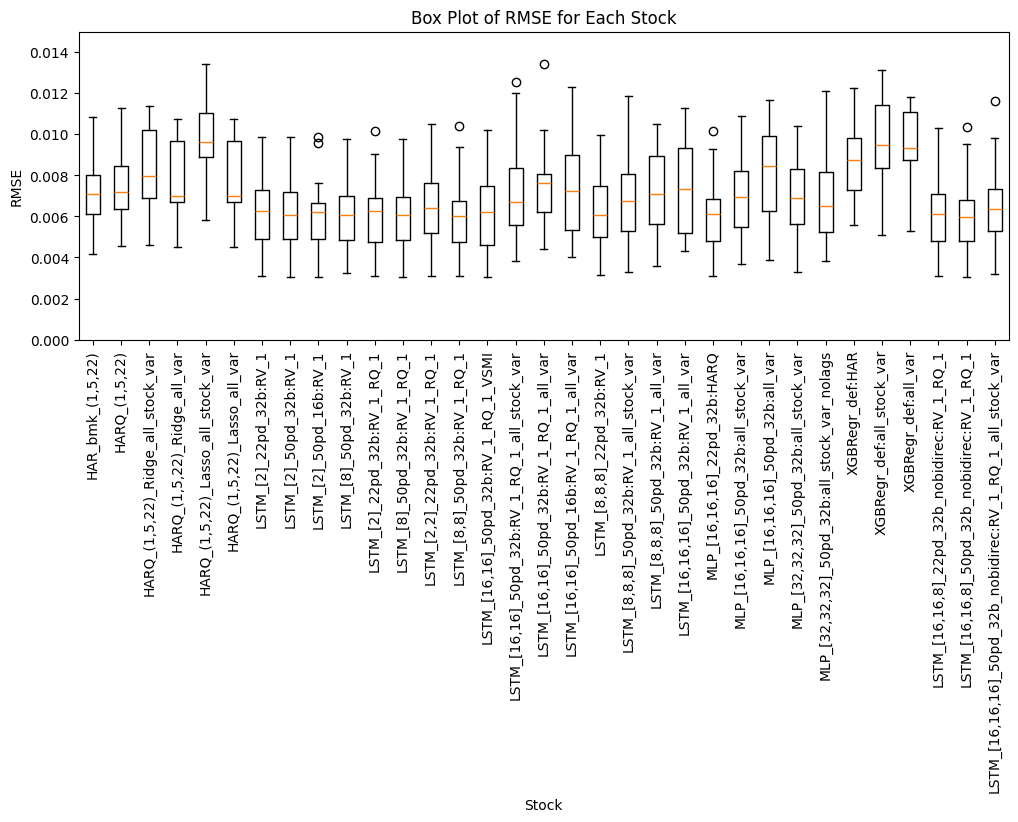

<Figure size 640x480 with 0 Axes>

In [58]:
box_plot_temp = rmse_df.copy()
plt.figure(figsize=(12, 4))  # Set the dimensions of the plot
plt.boxplot(box_plot_temp.values.T)
plt.xticks(range(1, len(box_plot_temp.index) + 1), box_plot_temp.index, rotation=90)
plt.xlabel('Stock')
plt.ylabel('RMSE')
plt.title('Box Plot of RMSE for Each Stock')
plt.ylim(0, 0.0150)  # Set the y-axis limits
plt.savefig('box_plot.png')  # Save the plot as 'box_plot.png'
plt.show()

plt.savefig('results_plots_tables/box_plot_v4.png')


In [61]:
test_dmw_test_df = dmw_test_df.copy()
test_dmw_test_df = test_dmw_test_df.map(lambda x: 0 if x < 0.05 else 1)
test_dmw_test_df

,ABBN_t,ABBN_pval,CFR_t,CFR_pval,GEBN_t,GEBN_pval,GIVN_t,GIVN_pval,HOLN_t,HOLN_pval,...,SIKA_t,SIKA_pval,SOON_t,SOON_pval,SREN_t,SREN_pval,UBSG_t,UBSG_pval,ZURN_t,ZURN_pval
"HAR_bmk_(1,5,22)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"HARQ_(1,5,22)",0,0,0,1,0,1,0,1,0,1,...,1,1,0,1,0,1,1,1,0,0
"HARQ_(1,5,22)_Ridge_all_stock_var",0,0,1,1,0,1,1,1,0,0,...,1,1,1,1,1,1,0,0,0,0
"HARQ_(1,5,22)_Ridge_all_var",1,1,1,1,0,1,1,1,1,1,...,1,1,1,1,1,1,0,0,1,1
"HARQ_(1,5,22)_Lasso_all_stock_var",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"HARQ_(1,5,22)_Lasso_all_var",1,1,1,1,0,1,1,1,1,1,...,1,1,1,1,1,1,0,0,1,1
LSTM_[2]_22pd_32b:RV_1,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
LSTM_[2]_50pd_32b:RV_1,0,0,0,1,0,0,0,0,1,1,...,1,1,0,0,1,1,0,1,0,0
LSTM_[2]_50pd_16b:RV_1,0,0,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,1,1,0,1
LSTM_[8]_50pd_32b:RV_1,1,1,1,1,0,0,0,0,1,1,...,0,0,0,1,0,0,1,1,0,1


In [27]:
test_dmw_test_df.to_latex('results_plots_tables/dmw_test_bool_v4.tex')
test_dmw_test_df.to_sql('dmw_test_bool_v4_final', con=conn)

In [62]:
dmw_by_model_bool = test_dmw_test_df.filter(regex='_pval$').T.sum()
dmw_by_model_bool.to_sql('dmw_by_model_bool_v4_final', con=conn)
dmw_by_model_bool

HAR_bmk_(1,5,22)                                               0
HARQ_(1,5,22)                                                 13
HARQ_(1,5,22)_Ridge_all_stock_var                             11
HARQ_(1,5,22)_Ridge_all_var                                   14
HARQ_(1,5,22)_Lasso_all_stock_var                              0
HARQ_(1,5,22)_Lasso_all_var                                   14
LSTM_[2]_22pd_32b:RV_1                                         8
LSTM_[2]_50pd_32b:RV_1                                         7
LSTM_[2]_50pd_16b:RV_1                                         7
LSTM_[8]_50pd_32b:RV_1                                         9
LSTM_[2]_22pd_32b:RV_1_RQ_1                                   11
LSTM_[8]_50pd_32b:RV_1_RQ_1                                   10
LSTM_[2,2]_22pd_32b:RV_1_RQ_1                                 10
LSTM_[8,8]_50pd_32b:RV_1_RQ_1                                 12
LSTM_[16,16]_50pd_32b:RV_1_RQ_1_VSMI                           9
LSTM_[16,16]_50pd_32b:RV_

### Test reading saved data

In [51]:
conn2 = sqlite3.connect('results_plots_tables/results.db')

all_tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table'", conn2)
all_tables.index.name = 'table_id'
all_tables.columns = ['table_name']
all_tables

,table_name
table_id,
0,rmse_v4_final
1,violation_ratio_v4_final
2,dmw_test_v4_final
3,dmw_test_bool_v4_final
4,dmw_by_model_bool_v4_final


In [49]:
rmse_results = pd.read_sql('SELECT * FROM rmse_v4_final', con=conn2).set_index('index')
rmse_results.index.name = 'model'
rmse_results

,ABBN,CFR,GEBN,GIVN,HOLN,KNIN,LONN,NESN,NOVN,PGHN,ROG,SCMN,SIKA,SOON,SREN,UBSG,ZURN
model,,,,,,,,,,,,,,,,,
"HAR_bmk_(1,5,22)",0.007113,0.010822,0.006969,0.005802,0.007268,0.008013,0.007081,0.004179,0.005444,0.009018,0.006113,0.004858,0.007476,0.010215,0.007876,0.008787,0.006790
"HARQ_(1,5,22)",0.007512,0.011298,0.007009,0.005902,0.007357,0.008442,0.007126,0.004550,0.005428,0.009177,0.006362,0.004884,0.007113,0.010321,0.008172,0.008782,0.007187
"HARQ_(1,5,22)_Ridge_all_stock_var",0.035176,0.010225,0.007086,0.005679,0.011386,0.008021,0.006890,0.055653,0.005350,0.008397,0.006780,0.004605,0.007083,0.009696,0.007241,1.442226,0.007945
"HARQ_(1,5,22)_Ridge_all_var",0.006706,0.010209,0.006985,0.005508,0.006811,0.007843,0.006904,0.039463,0.097460,0.008577,0.005582,0.004492,0.006888,0.009667,0.007228,0.010734,0.006223
"HARQ_(1,5,22)_Lasso_all_stock_var",0.009524,0.013194,0.009611,0.008913,0.009723,0.011013,0.009262,0.005846,0.006695,0.012983,0.007504,0.005887,0.009763,0.013434,0.010805,0.011339,0.008881
"HARQ_(1,5,22)_Lasso_all_var",0.006706,0.010209,0.006985,0.005508,0.006811,0.007843,0.006904,0.039463,0.097460,0.008577,0.005582,0.004492,0.006888,0.009667,0.007228,0.010734,0.006223
LSTM_[2]_22pd_32b:RV_1,0.005736,0.009871,0.006262,0.005048,0.006277,0.007289,0.006182,0.003104,0.004143,0.007600,0.004901,0.003889,0.006639,0.009450,0.007066,0.007880,0.004788
LSTM_[2]_50pd_32b:RV_1,0.005854,0.009859,0.006184,0.005105,0.006066,0.008017,0.006147,0.003067,0.004061,0.007180,0.004907,0.003869,0.006228,0.009166,0.005887,0.007775,0.004492
LSTM_[2]_50pd_16b:RV_1,0.005815,0.009849,0.006236,0.005164,0.006068,0.007445,0.006227,0.003044,0.004018,0.006671,0.004909,0.003875,0.006607,0.009574,0.006352,0.007637,0.004404


In [48]:
violation_ratio_results = pd.read_sql('SELECT * FROM violation_ratio_v4_final', con=conn2).set_index('index')
violation_ratio_results.index.name = 'model'
violation_ratio_results

,ABBN,CFR,GEBN,GIVN,HOLN,KNIN,LONN,NESN,NOVN,PGHN,ROG,SCMN,SIKA,SOON,SREN,UBSG,ZURN
model,,,,,,,,,,,,,,,,,
"HAR_bmk_(1,5,22)",0.061611,0.058057,0.071090,0.063981,0.067536,0.073460,0.077014,0.062796,0.058057,0.086493,0.048578,0.049763,0.078199,0.072275,0.073460,0.061611,0.072275
"HARQ_(1,5,22)",0.063981,0.063981,0.063981,0.056872,0.068720,0.077014,0.067536,0.061611,0.055687,0.085308,0.046209,0.049763,0.075829,0.073460,0.075829,0.060427,0.071090
"HARQ_(1,5,22)_Ridge_all_stock_var",0.149289,0.046209,0.080569,0.063981,0.119668,0.084123,0.074645,0.149289,0.047393,0.080569,0.055687,0.049763,0.078199,0.069905,0.075829,0.719194,0.071090
"HARQ_(1,5,22)_Ridge_all_var",0.058057,0.053318,0.085308,0.065166,0.053318,0.078199,0.073460,0.710900,0.272512,0.094787,0.059242,0.040284,0.077014,0.072275,0.081754,0.081754,0.075829
"HARQ_(1,5,22)_Lasso_all_stock_var",0.095972,0.114929,0.124408,0.122038,0.059242,0.139810,0.116114,0.084123,0.062796,0.140995,0.075829,0.058057,0.105450,0.142180,0.119668,0.091232,0.111374
"HARQ_(1,5,22)_Lasso_all_var",0.058057,0.053318,0.085308,0.065166,0.053318,0.078199,0.073460,0.710900,0.272512,0.094787,0.059242,0.040284,0.077014,0.072275,0.081754,0.081754,0.075829
LSTM_[2]_22pd_32b:RV_1,0.058323,0.059538,0.070474,0.063183,0.066829,0.072904,0.071689,0.061968,0.055893,0.099635,0.031592,0.042527,0.087485,0.080194,0.088700,0.063183,0.082625
LSTM_[2]_50pd_32b:RV_1,0.059119,0.060377,0.070440,0.066667,0.066667,0.094340,0.074214,0.062893,0.057862,0.093082,0.055346,0.046541,0.076730,0.072956,0.069182,0.061635,0.075472
LSTM_[2]_50pd_16b:RV_1,0.060377,0.061635,0.072956,0.067925,0.066667,0.075472,0.074214,0.059119,0.057862,0.079245,0.054088,0.037736,0.088050,0.086792,0.089308,0.061635,0.072956


In [45]:
dmw_test_results = pd.read_sql('SELECT * FROM dmw_test_v4_final', con=conn2).set_index('index')
dmw_test_results.index.name = 'model'
dmw_test_results

,ABBN_t,ABBN_pval,CFR_t,CFR_pval,GEBN_t,GEBN_pval,GIVN_t,GIVN_pval,HOLN_t,HOLN_pval,...,SIKA_t,SIKA_pval,SOON_t,SOON_pval,SREN_t,SREN_pval,UBSG_t,UBSG_pval,ZURN_t,ZURN_pval
model,,,,,,,,,,,,,,,,,,,,,
"HAR_bmk_(1,5,22)",0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,...,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00
"HARQ_(1,5,22)",-2.233246,1.289722e-02,-1.546583,6.116955e-02,-0.522589,3.006987e-01,-0.877708,1.901761e-01,-0.665210,2.530491e-01,...,3.610718,9.998383e-01,-1.441793,7.486610e-02,-1.645878,5.008084e-02,0.088759,5.353529e-01,-1.826044,3.409860e-02
"HARQ_(1,5,22)_Ridge_all_stock_var",-10.376475,4.012611e-24,1.681729,9.535041e-01,-1.304702,9.617518e-02,0.695786,7.566227e-01,-5.172192,1.446161e-07,...,2.469285,9.931322e-01,2.293084,9.889557e-01,2.257047,9.878698e-01,-8.369462,1.195982e-16,-4.233938,1.274379e-05
"HARQ_(1,5,22)_Ridge_all_var",1.035560,8.496479e-01,1.706323,9.558418e-01,-0.127093,4.494485e-01,1.790542,9.631373e-01,1.785053,9.626939e-01,...,2.503064,9.937498e-01,2.277666,9.885020e-01,2.325395,9.898563e-01,-3.344706,4.300367e-04,2.666116,9.960899e-01
"HARQ_(1,5,22)_Lasso_all_stock_var",-6.637022,2.862341e-11,-7.661301,2.526800e-14,-9.511859,9.504691e-21,-9.593901,4.650773e-21,-4.859398,7.019594e-07,...,-7.283832,3.726345e-13,-8.809226,3.543814e-18,-7.076850,1.551955e-12,-6.613010,3.340568e-11,-5.334808,6.148608e-08
"HARQ_(1,5,22)_Lasso_all_var",1.035560,8.496479e-01,1.706323,9.558418e-01,-0.127093,4.494485e-01,1.790542,9.631373e-01,1.785053,9.626939e-01,...,2.503064,9.937498e-01,2.277666,9.885020e-01,2.325395,9.898563e-01,-3.344706,4.300367e-04,2.666116,9.960899e-01
LSTM_[2]_22pd_32b:RV_1,0.534897,7.035672e-01,0.919440,8.209324e-01,-5.442917,3.461186e-08,-6.219868,3.957298e-10,-0.336774,3.681868e-01,...,-4.693985,1.569080e-06,-6.099164,8.199319e-10,-5.045713,2.782005e-07,-0.510412,3.049500e-01,-2.018032,2.195617e-02
LSTM_[2]_50pd_32b:RV_1,-4.690152,1.606727e-06,0.033741,5.134540e-01,-6.087329,8.930178e-10,-7.793794,1.018943e-14,0.064410,5.256700e-01,...,0.522851,6.993881e-01,-1.659864,4.866832e-02,1.940990,9.736935e-01,-0.968102,1.666440e-01,-2.946875,1.652003e-03
LSTM_[2]_50pd_16b:RV_1,-4.486917,4.146870e-06,0.325557,6.275774e-01,-7.432913,1.376249e-13,-8.184294,5.433697e-16,-0.004695,4.981277e-01,...,-5.194997,1.302226e-07,-7.939844,3.451537e-15,-6.894968,5.497048e-12,1.284673,9.003594e-01,-0.103089,4.589591e-01


In [39]:
dmw_test_bool_results = pd.read_sql('SELECT * FROM dmw_test_bool_v4_final', con=conn2)
dmw_test_bool_results

,index,ABBN_t,ABBN_pval,CFR_t,CFR_pval,GEBN_t,GEBN_pval,GIVN_t,GIVN_pval,HOLN_t,...,SIKA_t,SIKA_pval,SOON_t,SOON_pval,SREN_t,SREN_pval,UBSG_t,UBSG_pval,ZURN_t,ZURN_pval
0,"HAR_bmk_(1,5,22)",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"HARQ_(1,5,22)",0,0,0,1,0,1,0,1,0,...,1,1,0,1,0,1,1,1,0,0
2,"HARQ_(1,5,22)_Ridge_all_stock_var",0,0,1,1,0,1,1,1,0,...,1,1,1,1,1,1,0,0,0,0
3,"HARQ_(1,5,22)_Ridge_all_var",1,1,1,1,0,1,1,1,1,...,1,1,1,1,1,1,0,0,1,1
4,"HARQ_(1,5,22)_Lasso_all_stock_var",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,"HARQ_(1,5,22)_Lasso_all_var",1,1,1,1,0,1,1,1,1,...,1,1,1,1,1,1,0,0,1,1
6,LSTM_[2]_22pd_32b:RV_1,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
7,LSTM_[2]_50pd_32b:RV_1,0,0,0,1,0,0,0,0,1,...,1,1,0,0,1,1,0,1,0,0
8,LSTM_[2]_50pd_16b:RV_1,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,1
9,LSTM_[8]_50pd_32b:RV_1,1,1,1,1,0,0,0,0,1,...,0,0,0,1,0,0,1,1,0,1


In [54]:
dmw_test_bool_bymodel_results = pd.read_sql('SELECT * FROM dmw_by_model_bool_v4_final', con=conn2).set_index('index')
dmw_test_bool_bymodel_results.index.name = 'model'
dmw_test_bool_bymodel_results.columns = ['freq_significant']
dmw_test_bool_bymodel_results

,freq_significant
model,
"HAR_bmk_(1,5,22)",0
"HARQ_(1,5,22)",13
"HARQ_(1,5,22)_Ridge_all_stock_var",11
"HARQ_(1,5,22)_Ridge_all_var",14
"HARQ_(1,5,22)_Lasso_all_stock_var",0
"HARQ_(1,5,22)_Lasso_all_var",14
LSTM_[2]_22pd_32b:RV_1,8
LSTM_[2]_50pd_32b:RV_1,7
LSTM_[2]_50pd_16b:RV_1,7
